In [1]:
import pandas as pd
import math
import datetime as dt
import time
import json
import numpy as np
import warnings
import tqdm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

from xgboost import XGBClassifier

import torch
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier

import sklearn
from sklearn import svm

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel

from sklearn.impute import KNNImputer

from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
from Sleep_Stress_new_features import preprocessing

# With call and sms data

In [3]:
uid_list = ['u00', 'u01', 'u02', 'u03', 'u04', 'u07', 'u08', 'u09', 'u10', 'u12', #'u13',
            'u14', 'u15', 'u16', 'u17',
      'u18', 'u19', 'u20', 'u22', 'u23', 'u24', 'u25', 'u27', 'u30', 'u31', 'u32', 'u33', 'u34', 'u35', 'u36', 
      'u39', 'u41', 'u42', 'u43', 'u44', 'u45', 'u46', 'u47','u49', 'u50', 'u51', 'u52', 'u53', 'u54', 'u56', 
      'u57', 'u58' ,'u59']

dataframes = []
for uid in uid_list:
    try:
        df = preprocessing(uid)
        dataframes.append((uid, df))
        print(uid, len(df))
    except:
        pass

u00 10
u02 7
u08 25
u12 7
u24 8
u31 2
u36 12
u46 6
u47 1
u49 5
u50 0
u51 6
u54 3
u56 0
u57 13
u58 14
u59 35


# Predicting Stress and Sleep:

In [4]:
def transform_df(dataframe):
    ## obtain the dates as a column and re-index the dataframes
    re_index_data = []

    for tup in dataframe:
        test = tup[1]
        test = test.rename_axis('date').reset_index()
        re_index_data.append((tup[0], test))
    return re_index_data

In [5]:
transformed_data = transform_df(dataframes)

In [6]:
transformed_dataframes = [tup[1] for tup in transformed_data]

In [7]:
df3 = pd.concat(transformed_dataframes)
df3 = df3.sort_values(by='date')
max_range = len(df3)
df3 = df3.drop(['date', "Mean_rate_sleep", "Mean_social_sleep",
              "Std_hour_sleep", "Std_rate_sleep", "Std_social_sleep", 
              'Median_hour_sleep', 'Median_rate_sleep', 'Median_social_sleep',
              'Min_hour_sleep', 'Min_rate_sleep', 'Min_social_sleep', 
              'Max_hour_sleep', 'Max_rate_sleep', 'Max_social_sleep',
              'Skew_hour_sleep', 'Skew_rate_sleep', 'Skew_social_sleep',
              'Var_hour_sleep', 'Var_rate_sleep', 'Var_social_sleep'], axis=1)
df3 = df3.reset_index(drop=True)
df3

,Mean_Call_Duration,Std_Call_Duration,Median_Call_Duration,Min_Call_Duration,Max_Call_Duration,Skew_Call_Duration,Var_Call_Duration,Mean_Activity_inference,Std_Activity_inference,Median_Activity_inference,...,Var_number_social,Sum_number_social,Mean_stress_level,Std_stress_level,Median_stress_level,Min_stress_level,Max_stress_level,Skew_stress_level,Var_stress_level,Sum_stress_level
0,130.698587,202.457750,93.193093,0.000000,1002.000000,3.646713,4.098914e+04,0.294428,0.695228,0,...,0.000000,4,1.0,0.000000,1.0,1,1,0.000000,0.000000,1
1,66.195011,10.472734,69.168490,22.000000,69.168490,-3.704326,1.096782e+02,0.313521,0.806401,0,...,0.250000,7,2.0,1.309307,1.0,1,4,0.989949,1.714286,14
2,42.657215,17.618854,44.813694,0.000000,86.000000,-0.640929,3.104240e+02,0.132745,0.446104,0,...,0.222222,7,2.0,1.309307,1.0,1,4,0.989949,1.714286,14
3,140.230874,29.240159,146.327869,0.000000,146.327869,-4.898979,8.549869e+02,0.098508,0.426783,0,...,0.000000,3,4.0,0.000000,4.0,4,4,0.000000,0.000000,4
4,56.636066,0.000000,56.636066,56.636066,56.636066,0.000000,5.048710e-29,0.248774,0.692781,0,...,0.000000,4,4.5,0.500000,4.5,4,5,0.000000,0.250000,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,105.000000,0.000000,105.000000,105.000000,105.000000,0.000000,0.000000e+00,0.115609,0.493460,0,...,0.000000,2,1.0,0.000000,1.0,1,1,0.000000,0.000000,1
150,59.269622,23.318115,69.168490,0.000000,69.168490,-2.230664,5.437345e+02,0.101164,0.440019,0,...,0.000000,8,2.0,0.000000,2.0,2,2,0.000000,0.000000,6
151,221.186513,68.222805,243.621037,0.000000,253.000000,-2.788408,4.654351e+03,0.056297,0.312272,0,...,0.000000,4,5.0,0.000000,5.0,5,5,0.000000,0.000000,5
152,83.181532,99.097467,69.168490,0.000000,562.000000,4.765912,9.820308e+03,0.191936,0.580720,0,...,0.000000,5,3.5,1.500000,3.5,2,5,0.000000,2.250000,7


# Correlation Analysis:

In [8]:
correlation_df = df3.corr()
correlation_df

,Mean_Call_Duration,Std_Call_Duration,Median_Call_Duration,Min_Call_Duration,Max_Call_Duration,Skew_Call_Duration,Var_Call_Duration,Mean_Activity_inference,Std_Activity_inference,Median_Activity_inference,...,Var_number_social,Sum_number_social,Mean_stress_level,Std_stress_level,Median_stress_level,Min_stress_level,Max_stress_level,Skew_stress_level,Var_stress_level,Sum_stress_level
Mean_Call_Duration,1.000000,0.600767,0.971189,0.240523,0.600838,0.153295,0.533421,-0.098758,-0.091919,NaN,...,0.046049,-0.039284,0.141569,-0.136461,0.149608,0.205927,0.026297,-0.056947,-0.108686,-0.126549
Std_Call_Duration,0.600767,1.000000,0.470475,-0.314732,0.976029,0.541088,0.874234,-0.009463,0.051395,NaN,...,0.134360,0.152044,0.027047,-0.016643,0.017444,0.058437,0.043907,0.115076,-0.007878,-0.000662
Median_Call_Duration,0.971189,0.470475,1.000000,0.251260,0.459081,0.026681,0.424854,-0.093369,-0.088264,NaN,...,0.038258,-0.053368,0.155721,-0.103438,0.167336,0.194716,0.044791,-0.075098,-0.076691,-0.116561
Min_Call_Duration,0.240523,-0.314732,0.251260,1.000000,-0.191497,-0.014408,-0.151385,-0.029511,-0.118113,NaN,...,-0.046435,-0.099164,0.013683,-0.207894,0.027819,0.114170,-0.106479,-0.111091,-0.188167,-0.140387
Max_Call_Duration,0.600838,0.976029,0.459081,-0.191497,1.000000,0.590431,0.871173,-0.007401,0.042443,NaN,...,0.153154,0.162920,-0.000651,-0.053832,-0.008163,0.054242,0.008868,0.116715,-0.044577,-0.022769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Min_stress_level,0.205927,0.058437,0.194716,0.114170,0.054242,-0.068069,0.092468,-0.246053,-0.296738,NaN,...,-0.064972,-0.161219,0.852475,-0.392752,0.846111,1.000000,0.408432,-0.170375,-0.359425,-0.121339
Max_stress_level,0.026297,0.043907,0.044791,-0.106479,0.008868,-0.036131,0.013133,0.353296,0.332415,NaN,...,0.177831,0.378218,0.779863,0.668168,0.604963,0.408432,1.000000,0.234307,0.654146,0.723954
Skew_stress_level,-0.056947,0.115076,-0.075098,-0.111091,0.116715,0.145939,0.038274,0.354249,0.349024,NaN,...,0.122979,0.347109,-0.173153,0.321703,-0.376644,-0.170375,0.234307,1.000000,0.259120,0.273120
Var_stress_level,-0.108686,-0.007878,-0.076691,-0.188167,-0.044577,-0.018956,-0.060150,0.536162,0.552478,NaN,...,0.185879,0.462463,0.123211,0.965380,-0.050489,-0.359425,0.654146,0.259120,1.000000,0.761979


In [9]:
## Investigate correlation analysis with only the label 

In [10]:
correlation_df['Mean_hour_sleep'].dropna().sort_values(ascending=False)[:10]

Mean_hour_sleep              1.000000
Max_phone_charge_duration    0.372201
Max_phone_lock_duration      0.364116
Std_phone_lock_duration      0.285335
Var_phone_charge_duration    0.278686
Var_phone_lock_duration      0.275185
Max_dark_duration            0.266852
Mean_phone_lock_duration     0.250073
Var_dark_duration            0.242024
Mean_dark_duration           0.229002
Name: Mean_hour_sleep, dtype: float64

In [11]:
#fig, axs = plt.subplots(1,1, figsize=(14,10))
#s = 100

#axs.scatter(df3['Mean_stress_level'],df3['number of distinct locations'], s=100, zorder=-5)

#for axis in ['top','bottom','left','right']:
 #   axs.spines[axis].set_linewidth(6)
    
#axs.grid(True)
#axs.set_ylabel('Number of distinct locations', fontsize=60)
#axs.xaxis.set_ticks_position('both')
#axs.set_xlabel('Mean stress level', fontsize=60)
#axs.yaxis.set_ticks_position('both')
#axs.tick_params(which='both', length=30, width=6, direction="in", pad=10)


#axs.tick_params(labelsize=35)

#plt.tight_layout()

# Feature Vector:

In [12]:
df4 = df3.drop(['Mean_hour_sleep'], axis=1)
X = df4.to_numpy()
## 0 -> Not enough sleep
## 1 -> Enough sleep
y = np.array([0 if val<9 else 1 for val in df3['Mean_hour_sleep']])
y = y.astype('int')

In [13]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)

The shape of X is (154, 99)
The shape of y is (154,)


## Feature Normalization:

In [14]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

## Feature Selection:

In [15]:
estimator = RandomForestClassifier(n_estimators = 100)
sel = RFECV(estimator, step=1, cv=5)
sel.fit(X_norm, y)

RFECV(cv=5, estimator=RandomForestClassifier())

In [16]:
sel.get_support()

array([False, False, False,  True,  True, False, False, False, False,
       False, False, False, False,  True, False, False,  True, False,
       False, False,  True,  True,  True, False, False, False, False,
       False,  True, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False,  True,  True,
       False, False,  True, False,  True,  True,  True, False, False,
        True, False,  True,  True, False, False, False,  True, False,
       False, False, False,  True, False,  True, False, False, False,
       False,  True, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False])

In [17]:
feature_name = df4.columns.to_numpy()
important_features = feature_name[sel.get_support()]
important_features

array(['Min_Call_Duration', 'Max_Call_Duration', 'Var_Activity_inference',
       'Std_audio_inference', 'Skew_audio_inference',
       'Var_audio_inference', 'Sum_audio_inference', 'Skew_conv_duration',
       'Min_dark_duration', 'Max_longitude', 'Skew_latitude',
       'Skew_longitude', 'Var_longitude', 'Sum_travelstate',
       'Mean_phone_charge_duration', 'Std_phone_charge_duration',
       'Max_phone_charge_duration', 'Var_phone_charge_duration',
       'Mean_phone_lock_duration', 'Max_phone_lock_duration',
       'Mean_pic_id', 'Median_pic_id', 'Sum_pic_id', 'Sum_number_social'],
      dtype=object)

In [18]:
X_important = X_norm[:,sel.get_support()]

In [19]:
X_important.shape

(154, 24)

## Train, Test split:

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_important,y, test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((107, 24), (47, 24), (107,), (47,))

# XGBoost: 

In [24]:
xgb_model = XGBClassifier(booster = 'gbtree', use_label_encoder=False)
xgb_tree_parameters = {'eta': [0.1, 0.01], 'max_depth':[6, 7, 8],
                       'learning_rate': [0.05, 0.005],
                      'sampling_method':['uniform', 'gradient_based'], 
                      'tree_method': ['auto'], 'max_bin': [64, 128],
                      'lambda':[1, 0.1, 0.01], 'alpha':[1, 0.1, 0.01]}

In [25]:
%%time
xgb_tree = GridSearchCV(xgb_model, xgb_tree_parameters, refit=True, n_jobs = -1, verbose=2) ## 5 cross val folds
xgb_tree.fit(X_train, y_train, eval_metric= 'logloss')
xgb_tree_best = xgb_tree.best_estimator_

print('*'*20, 'Validation', '*'*20)
print(classification_report(y_val, xgb_tree.predict(X_val)))
print('\n')
print('*'*20, 'Best estimator:', '*'*20, '\n', xgb_tree.best_estimator_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
******************** Validation ********************
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        37
           1       0.00      0.00      0.00        10

    accuracy                           0.79        47
   macro avg       0.39      0.50      0.44        47
weighted avg       0.62      0.79      0.69        47



******************** Best estimator: ******************** 
 XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              lambda=1, learning_rate=0.05, max_bin=64, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=1, 

In [26]:
feat_importances_xgb_tree = pd.DataFrame(zip(important_features, 
                                             xgb_tree_best.feature_importances_), 
                                         columns = ['Features', 'Importance'])

In [27]:
#feat_importances_xgb_tree

In [28]:
ordered_feat_imp_tree = feat_importances_xgb_tree.sort_values(by=['Importance'])

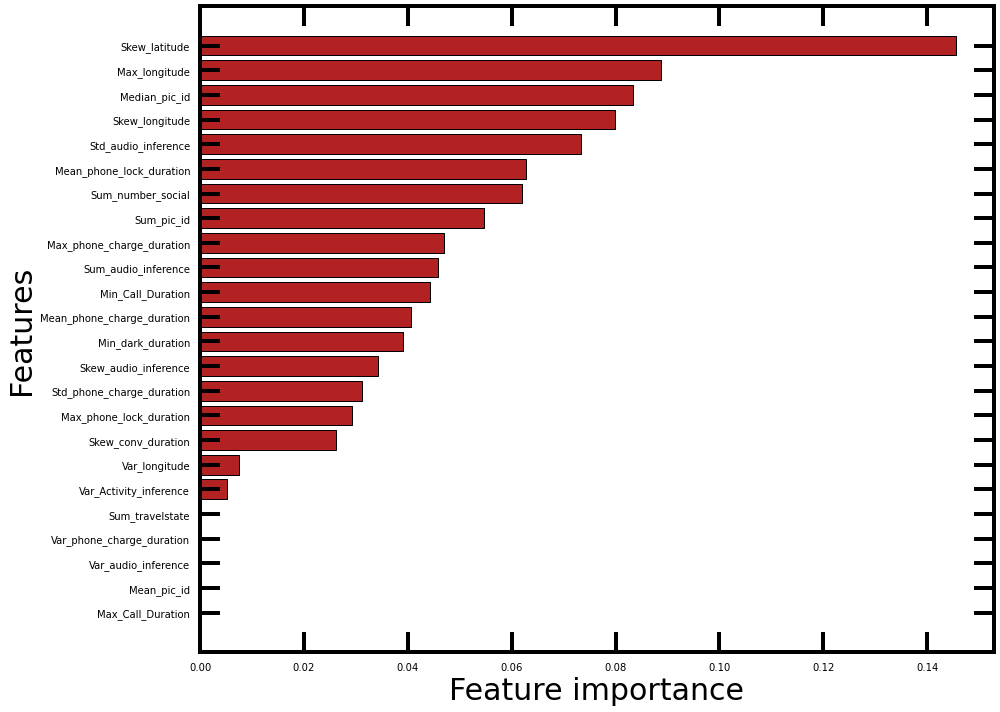

In [29]:
fig, axs = plt.subplots(1,1, figsize=(14,10))


axs.barh(ordered_feat_imp_tree['Features'], ordered_feat_imp_tree['Importance'], ec='black', color='firebrick')

for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(4)
    
#axs.grid(True)
axs.set_xlabel('Feature importance', fontsize=30)
axs.xaxis.set_ticks_position('both')
axs.set_ylabel('Features', fontsize=30)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)

axs.tick_params(labelsize=10)

plt.tight_layout()
#fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/xgb_tree_feat_imp_no_txt_no_call', bbox_inches='tight')

In [30]:
xgb_model = XGBClassifier(booster = 'gblinear', use_label_encoder=False)
xgb_linear_parameters = {'updater': ['shotgun', 'coord_descent'],
                        'feature_selector': ['cyclic', 'shuffle'],
                        'lambda':[1, 0.1, 0.01], 'alpha':[1, 0.1, 0.01]}

In [31]:
%%time
xgb_linear = GridSearchCV(xgb_model, xgb_linear_parameters, refit=True, n_jobs = -1, verbose=2)
xgb_linear.fit(X_train, y_train, eval_metric= 'logloss')
xgb_linear_best = xgb_linear.best_estimator_
print('*'*20, 'Validation', '*'*20)
print(classification_report(y_val, xgb_linear_best.predict(X_val)))
print('\n')
print('Best estimator:', xgb_linear.best_estimator_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
******************** Validation ********************
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        37
           1       0.00      0.00      0.00        10

    accuracy                           0.79        47
   macro avg       0.39      0.50      0.44        47
weighted avg       0.62      0.79      0.69        47



Best estimator: XGBClassifier(alpha=1, base_score=0.5, booster='gblinear',
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, feature_selector='cyclic', gamma=None,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              lambda=1, learning_rate=0.5, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=4, num_parallel_tree=None,
              random_state=0, reg_alpha=0,

The concept of feature importance is specific to decision trees, as the definition specifically refers to "splits"

In [32]:
xgb_model = XGBClassifier(booster = 'dart',use_label_encoder=False)
xgb_dart_parameters = {'sample_type': ['uniform'],
                      'normalize_type': ['tree', 'forest'], 'rate_drop': [0.1],
                       'skip_drop': [0.2,0.5], 'learning_rate':[0.2, 0.1, 0.01, 0.3, 0.02, 0.03, 0.5],
                      'eta': [0.01], 'max_depth': [6, 8], 'lambda':[1, 0.1, 0.01], 
                       'alpha':[0.1, 0.01]}

In [33]:
%%time
xgb_dart = GridSearchCV(xgb_model, xgb_dart_parameters, refit=True, n_jobs = -1, verbose=2)
xgb_dart.fit(X_train, y_train, eval_metric='logloss')
xgb_dart_best = xgb_dart.best_estimator_
print('*'*20, 'Validation', '*'*20)
print(classification_report(y_val, xgb_dart_best.predict(X_val)))
print('\n')
print('Best estimator:', xgb_dart.best_estimator_)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
******************** Validation ********************
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        37
           1       1.00      0.10      0.18        10

    accuracy                           0.81        47
   macro avg       0.90      0.55      0.54        47
weighted avg       0.85      0.81      0.74        47



Best estimator: XGBClassifier(alpha=0.1, base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              lambda=1, learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, normalize_type='tree',
              num_parallel_tree=1, random_state=0, rate_drop=0.1,
              reg_alpha=0.10000

In [75]:
feat_importances_xgb_dart = pd.DataFrame(zip(important_features, 
                                             xgb_dart_best.feature_importances_), 
                                         columns = ['Features', 'Importance'])

In [76]:
#feat_importances_xgb_dart

In [77]:
ordered_feat_imp_dart = feat_importances_xgb_dart.sort_values(by= ['Importance'])

In [78]:
ordered_feat_imp_dart = ordered_feat_imp_dart.reset_index()

In [96]:
ordered_feat_imp_dart

,index,Features,Importance
0,20,Mean_pic_id,0.000000
1,5,Var_audio_inference,0.000000
2,17,Var_phone_charge_duration,0.000000
3,13,Sum_travelstate,0.000000
4,10,Skew_latitude,0.007752
5,12,Var_longitude,0.010599
6,2,Var_Activity_inference,0.014637
7,1,Max_Call_Duration,0.019217
8,15,Std_phone_charge_duration,0.022829
9,4,Skew_audio_inference,0.035203


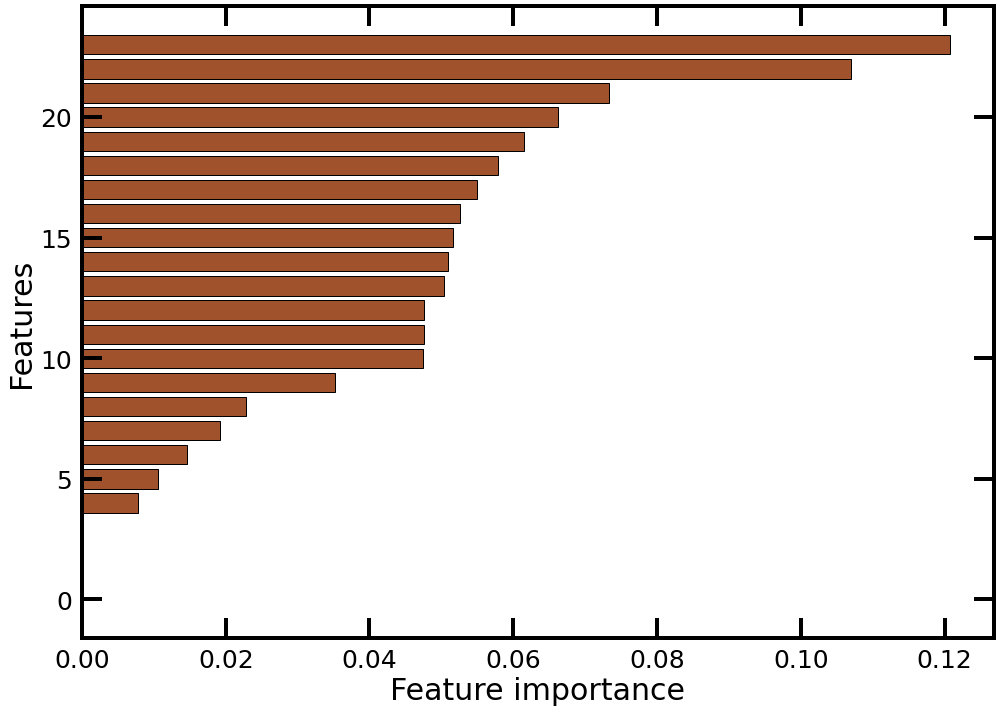

In [81]:
fig, axs = plt.subplots(1,1, figsize=(14,10))


axs.barh(ordered_feat_imp_dart.index, ordered_feat_imp_dart['Importance'], ec='black', 
         color='sienna')

for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(4)
    
#axs.grid(True)
axs.set_xlabel('Feature importance', fontsize=30)
axs.xaxis.set_ticks_position('both')
axs.set_ylabel('Features', fontsize=30)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)

axs.tick_params(labelsize=25)

plt.tight_layout()
fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/sleep_xgb_dart_feat_imp_with_txt_call.svg', bbox_inches='tight')

# TabNet:

In [40]:
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

In [98]:
clf1 = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                        n_d=8, n_a=8, n_steps=3, 
                        gamma=1.3, n_independent=3, n_shared=4, epsilon=1e-15, 
                        momentum=0.01, lambda_sparse=0.001, seed=0, clip_value=2, verbose=1, 
                       optimizer_params={'lr': 1e-3, 'weight_decay': 1e-3},
                        scheduler_params={'step_size':50,
                                         "gamma":0.90},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

Device used : cpu


In [99]:
clf1.fit(
    X_train,y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=1000 , patience=70,
    loss_fn = torch.nn.CrossEntropyLoss(),
    batch_size=256, virtual_batch_size=256,
    num_workers=0,
    weights=1,
    drop_last=False
)

epoch 0  | loss: 0.98954 | train_accuracy: 0.39252 | valid_accuracy: 0.44681 |  0:00:00s
epoch 1  | loss: 1.2662  | train_accuracy: 0.43925 | valid_accuracy: 0.3617  |  0:00:00s
epoch 2  | loss: 1.20346 | train_accuracy: 0.42056 | valid_accuracy: 0.38298 |  0:00:00s
epoch 3  | loss: 0.75904 | train_accuracy: 0.43925 | valid_accuracy: 0.38298 |  0:00:00s
epoch 4  | loss: 0.93048 | train_accuracy: 0.42991 | valid_accuracy: 0.40426 |  0:00:00s
epoch 5  | loss: 0.84061 | train_accuracy: 0.46729 | valid_accuracy: 0.42553 |  0:00:00s
epoch 6  | loss: 0.98728 | train_accuracy: 0.45794 | valid_accuracy: 0.48936 |  0:00:00s
epoch 7  | loss: 1.02982 | train_accuracy: 0.46729 | valid_accuracy: 0.48936 |  0:00:00s
epoch 8  | loss: 1.12865 | train_accuracy: 0.49533 | valid_accuracy: 0.51064 |  0:00:00s
epoch 9  | loss: 0.85529 | train_accuracy: 0.49533 | valid_accuracy: 0.40426 |  0:00:01s
epoch 10 | loss: 1.0734  | train_accuracy: 0.50467 | valid_accuracy: 0.46809 |  0:00:01s
epoch 11 | loss: 1.12

epoch 94 | loss: 0.49516 | train_accuracy: 0.74766 | valid_accuracy: 0.68085 |  0:00:09s
epoch 95 | loss: 0.54018 | train_accuracy: 0.74766 | valid_accuracy: 0.68085 |  0:00:09s
epoch 96 | loss: 0.47829 | train_accuracy: 0.75701 | valid_accuracy: 0.65957 |  0:00:09s
epoch 97 | loss: 0.4944  | train_accuracy: 0.75701 | valid_accuracy: 0.65957 |  0:00:09s
epoch 98 | loss: 0.67014 | train_accuracy: 0.75701 | valid_accuracy: 0.65957 |  0:00:10s
epoch 99 | loss: 0.43433 | train_accuracy: 0.7757  | valid_accuracy: 0.68085 |  0:00:10s
epoch 100| loss: 0.4411  | train_accuracy: 0.7757  | valid_accuracy: 0.68085 |  0:00:10s
epoch 101| loss: 0.56017 | train_accuracy: 0.7757  | valid_accuracy: 0.68085 |  0:00:10s
epoch 102| loss: 0.74463 | train_accuracy: 0.7757  | valid_accuracy: 0.65957 |  0:00:10s
epoch 103| loss: 0.39285 | train_accuracy: 0.7757  | valid_accuracy: 0.65957 |  0:00:11s
epoch 104| loss: 0.52115 | train_accuracy: 0.7757  | valid_accuracy: 0.65957 |  0:00:11s
epoch 105| loss: 0.50

In [71]:
preds_valid = clf1.predict(X_val)
valid_acc = accuracy_score(preds_valid, y_val)

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_acc}")

BEST ACCURACY SCORE ON VALIDATION SET : 0.723404255319149


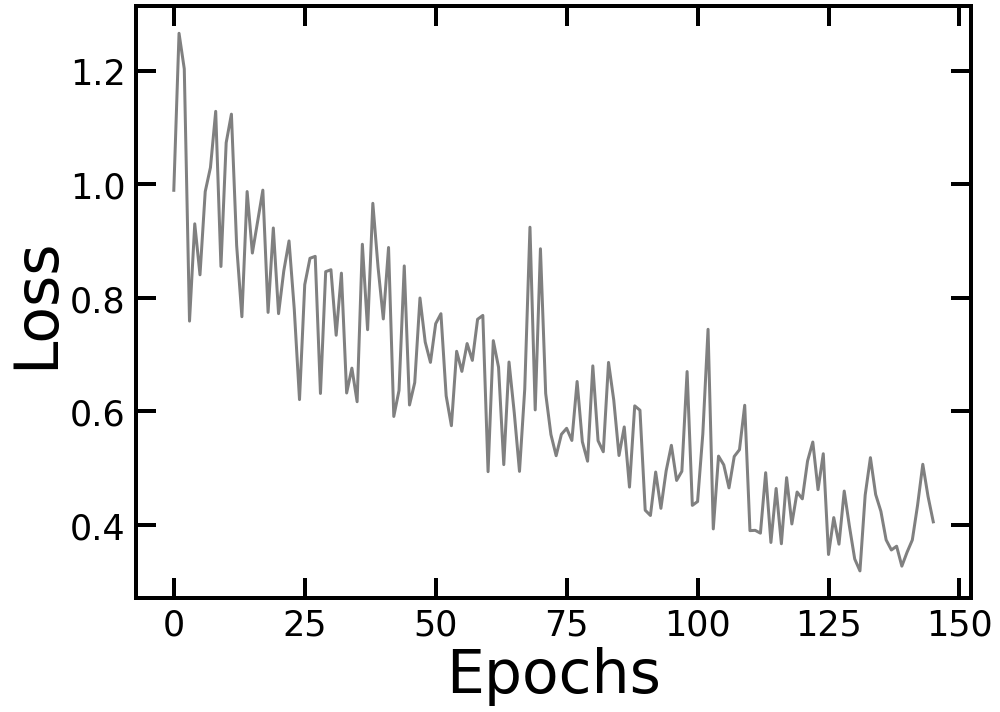

In [82]:
fig, axs = plt.subplots(1,1, figsize=(14,10))

axs.plot(clf1.history['loss'], linewidth=3, color='grey')

for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(4)
    
#axs.grid(True)
axs.set_ylabel('Loss', fontsize=60)
axs.xaxis.set_ticks_position('both')
axs.set_xlabel('Epochs', fontsize=60)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)


axs.tick_params(labelsize=35)

plt.tight_layout()
fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/sleep_tab_net_loss_with_txt_call.svg', bbox_inches='tight')

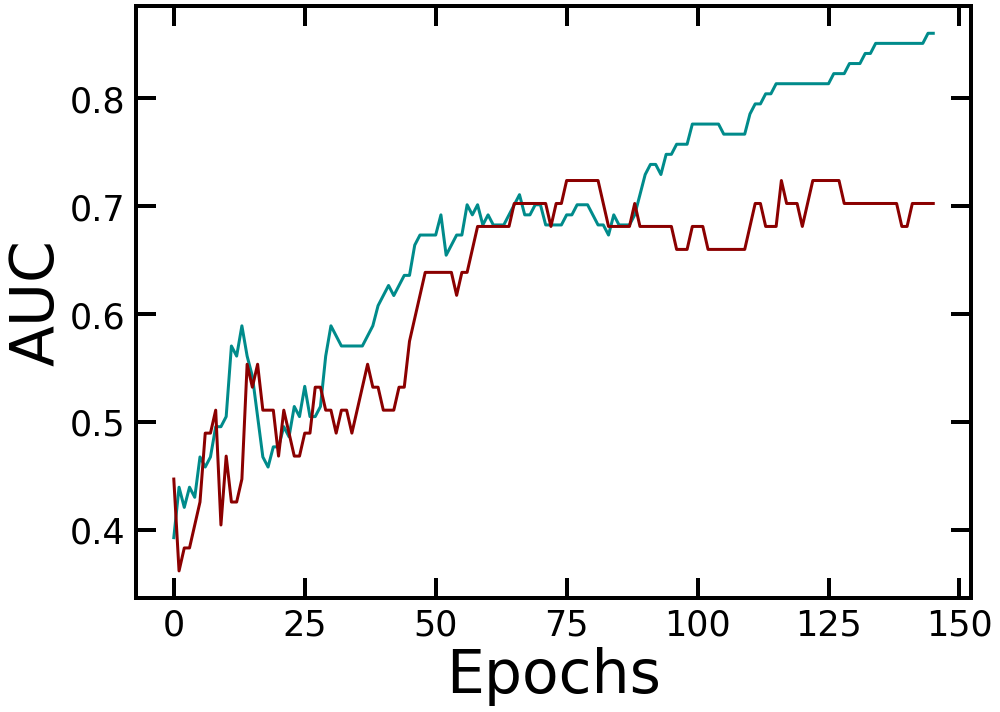

In [83]:
fig, axs = plt.subplots(1,1, figsize=(14,10))

axs.plot(clf1.history['train_accuracy'], linewidth=3, label = 'Training AUC', color='darkcyan')
axs.plot(clf1.history['valid_accuracy'], linewidth=3, label = 'Validation AUC', color='darkred')
for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(4)
    
#axs.grid(True)
axs.set_ylabel('AUC', fontsize=60)
axs.xaxis.set_ticks_position('both')
axs.set_xlabel('Epochs', fontsize=60)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)
#legend = axs.legend(borderpad=1, labelspacing=2, fontsize=15)
#legend.get_frame().set_linewidth(2.5)
#legend.get_frame().set_edgecolor('black')

axs.tick_params(labelsize=35)

plt.tight_layout()
fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/sleep_tabnet_auc_with_txt_call.svg', bbox_inches='tight')

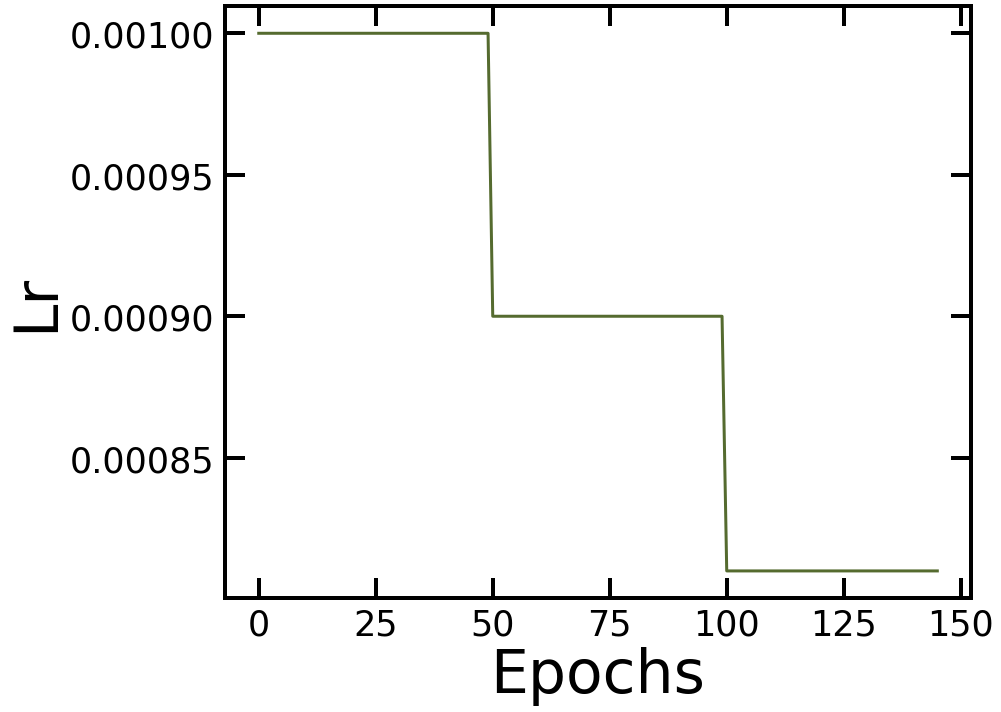

In [84]:
fig, axs = plt.subplots(1,1, figsize=(14,10))

axs.plot(clf1.history['lr'], linewidth=3, color = 'darkolivegreen')

for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(4)
    
#axs.grid(True)
axs.set_ylabel('Lr', fontsize=60)
axs.xaxis.set_ticks_position('both')
axs.set_xlabel('Epochs', fontsize=60)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)


axs.tick_params(labelsize=35)

plt.tight_layout()
fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/sleep_tabnet_lr_with_txt_call.svg', bbox_inches='tight')

In [100]:
feat_importances_tabnet = pd.DataFrame(zip(important_features, 
                                             clf1.feature_importances_), 
                                         columns = ['Features', 'Importance'])

In [101]:
feat_importances_tabnet

,Features,Importance
0,Min_Call_Duration,0.041284
1,Max_Call_Duration,0.023936
2,Var_Activity_inference,0.029842
3,Std_audio_inference,0.025877
4,Skew_audio_inference,0.018774
5,Var_audio_inference,0.029542
6,Sum_audio_inference,0.040835
7,Skew_conv_duration,0.040974
8,Min_dark_duration,0.059093
9,Max_longitude,0.038600


In [53]:
ordered_feat_imp_tabnet = feat_importances_tabnet.sort_values(by = ['Importance'])
ordered_feat_imp_tabnet = ordered_feat_imp_tabnet.reset_index()

In [95]:
ordered_feat_imp_tabnet

,index,Features,Importance
0,10,Skew_latitude,0.012268
1,4,Skew_audio_inference,0.018774
2,13,Sum_travelstate,0.023442
3,1,Max_Call_Duration,0.023936
4,3,Std_audio_inference,0.025877
5,19,Max_phone_lock_duration,0.026107
6,23,Sum_number_social,0.028356
7,5,Var_audio_inference,0.029542
8,2,Var_Activity_inference,0.029842
9,18,Mean_phone_lock_duration,0.033361


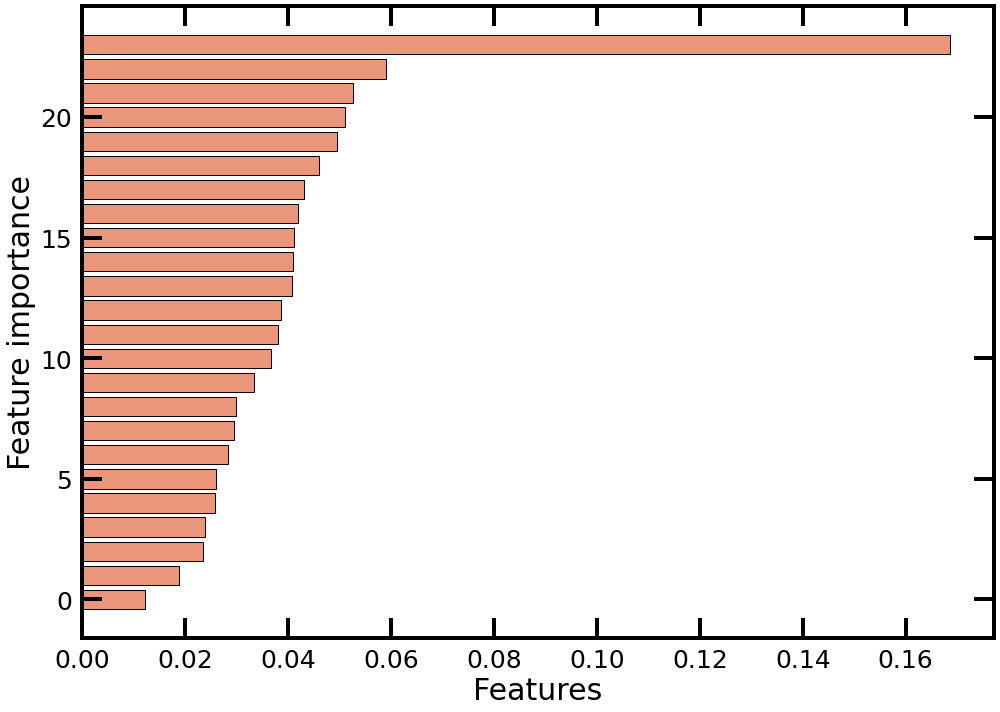

In [85]:
fig, axs = plt.subplots(1,1, figsize=(14,10))


axs.barh(ordered_feat_imp_tabnet.index, ordered_feat_imp_tabnet['Importance'], 
        ec='black', color='darksalmon')

for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(4)
    
#axs.grid(True)
axs.set_ylabel('Feature importance', fontsize=30)
axs.xaxis.set_ticks_position('both')
axs.set_xlabel('Features', fontsize=30)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)


axs.tick_params(labelsize=25)

plt.tight_layout()
fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/sleep_tabnet_feat_imp_with_txt_call.svg', bbox_inches='tight')

In [56]:
explain_matrix, masks = clf1.explain(X_val)

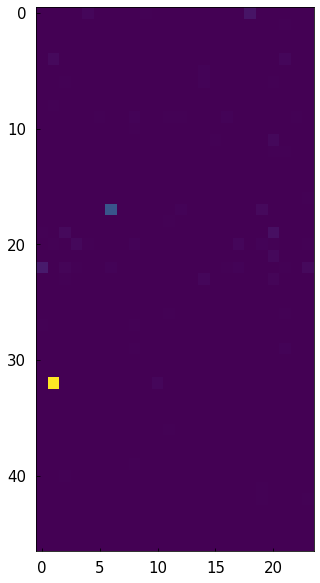

In [58]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))
axs.tick_params(which='both', direction="in", pad=10)
axs.tick_params(labelsize=15)
axs.imshow(explain_matrix)

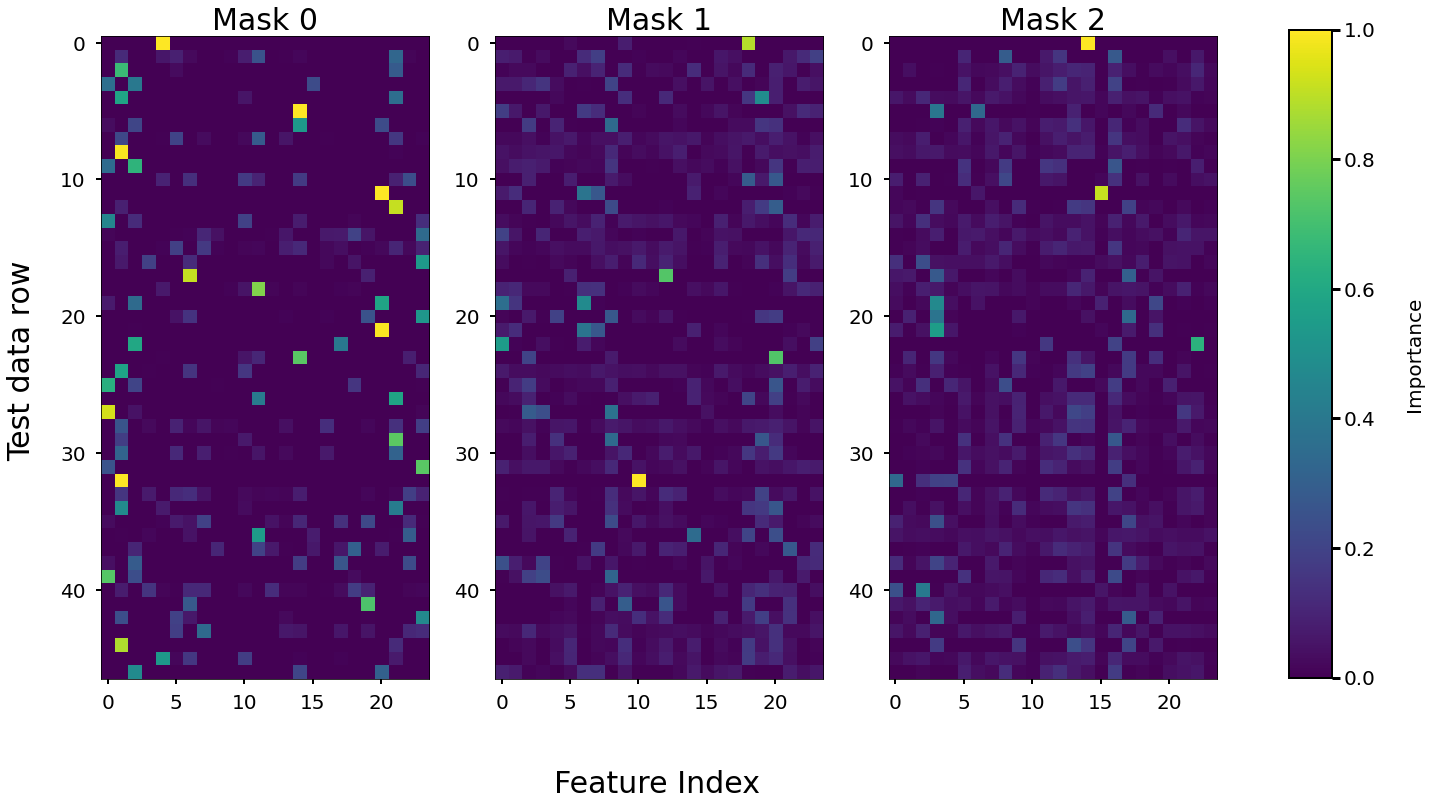

In [94]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    
    #axs[i].set_ylabel('Test Data Row', fontsize=30)
    #axs[i].set_xlabel('Feature index', fontsize=30)

    axs[i].tick_params(which='both', direction="out", pad=10,length=5, width=2)
    axs[i].tick_params(labelsize=20)
    im = axs[i].imshow(masks[i])
    axs[i].set_title(f"Mask {i}", fontsize=30)
    
fig.text(0.44, 0.2, 'Feature Index', fontsize=30)
fig.text(0.06, 0.5, 'Test data row', va='center', rotation='vertical', fontsize=30)

cax = fig.add_axes([0.95, 0.28, 0.03, 0.45])
cb = fig.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=20, length=8, width=3)
cb.outline.set_linewidth(2)
cb.set_label('Importance', fontsize = 20, rotation = 'vertical', labelpad=30)
fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/sleep_tabnet_masks_with_txt_call.svg', bbox_inches='tight')

In [135]:
#clf2 = TabNetClassifier(
#clf2_params = {'optimizer_fn':[torch.optim.Adam, torch.optim.Adamax],
 #            'optimizer_params':[dict(lr=2e-2), dict(lr=1e-2)],
  #             'n_steps':[3,5], 'momentum':[0.02, 0.05],
   #          'scheduler_params':[{"step_size":50, "gamma":0.9},{"step_size":10, "gamma":0.9}],
    #         'scheduler_fn': [torch.optim.lr_scheduler.LambdaLR, torch.optim.lr_scheduler.StepLR],
     #        'mask_type':['entmax', 'sparsemax']}
    
#clf_grid = GridSearchCV(clf2, clf2_params, scoring = sklearn.metrics.accuracy_score,
 #                       refit=True, n_jobs = -1, verbose=1)
#clf_grid.fit(
 #   X_train,y_train,
  #  eval_set=[(X_train, y_train), (X_val, y_val)],
   # eval_name=['train', 'valid'],
    #eval_metric=['auc'],
    #max_epochs=1000 , patience=50,
    #batch_size=256, virtual_batch_size=128,
    #num_workers=0,
    #weights=1,
    #drop_last=False
#)

In [137]:
#print('Best estimator:', clf_grid.best_estimator_)

Best estimator: TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.LambdaLR'>, scheduler_params={'step_size': 50, 'gamma': 0.9}, mask_type='entmax', input_dim=22, output_dim=2, device_name='auto')
